#**A20000908_Mostafa Walid**

**General requirements**

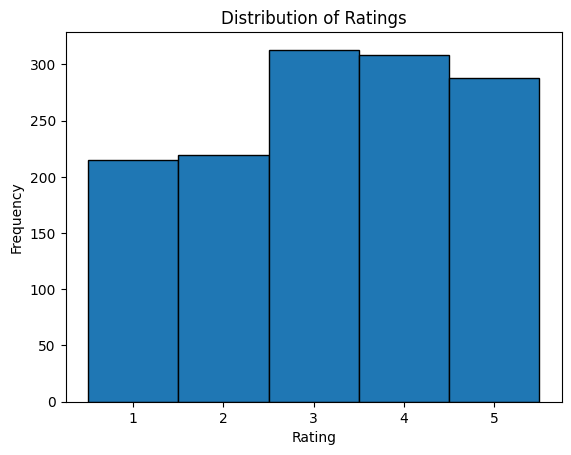

Matrix sparsity: 10.47%
Mean rating: 3.17
Rating counts:
3.0    313
4.0    308
5.0    288
2.0    219
1.0    215
Name: count, dtype: int64
Summary of Results:
num_users: 50
num_items: 30
ratings_per_item: {'Socialist Realism': 45, 'Come the Morning': 48, 'Nine Ball': 40, 'The Perfect Shadow': 41, 'Seevalaperi Pandi': 48, 'Universal Groove': 48, "The Killer's Game": 43, 'I giganti del cielo': 49, 'Land of Nairi': 45, 'The Promise of Perfume': 45, 'The Flash': 47, 'Moe': 44, 'American Surfrider': 44, "L'homme au bÃ¢ton, une lÃ©gende crÃ©ole": 45, 'Family Business': 46, "Rain Falls from Earth: Surviving Cambodia's Darkest Hour": 47, 'Neil': 44, 'A Small Problem': 43, "Maybe It's True What They Say About Us": 43, 'The Problem with People': 43, 'September': 42, 'The Last Voyage of the Demeter': 44, 'The Dog Thief': 46, 'Power Alley': 44, 'Falling Stars': 43, 'The Probe': 45, 'The Christmas Spirit': 46, 'Fear and Love: The Story of the Exorcist': 48, 'Amityville: Where the Echo Lives': 40, 'T

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("user_item_ratings.csv", index_col=0)

num_users = df.shape[1]
num_items = df.shape[0]

unique_users = df.columns.tolist()
unique_items = df.index.tolist()

ratings_per_item = df.notna().sum(axis=1)

all_ratings = df.stack().astype(float)
plt.hist(all_ratings, bins=np.arange(0.5, 6, 1), edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

total_possible_ratings = df.size
total_actual_ratings = df.notna().sum().sum()
sparsity = 1 - (total_actual_ratings / total_possible_ratings)

mean_rating = all_ratings.mean()
rating_counts = df.stack().value_counts()

print(f"Matrix sparsity: {sparsity:.2%}")
print(f"Mean rating: {mean_rating:.2f}")
print(f"Rating counts:\n{rating_counts}")

average_ratings_per_item = df.mean(axis=1)
lowest_rated_items = average_ratings_per_item.nsmallest(2).index.tolist()

results = {
    "num_users": num_users,
    "num_items": num_items,
    "ratings_per_item": ratings_per_item.to_dict(),
    "matrix_sparsity": sparsity,
    "mean_rating": mean_rating,
    "lowest_rated_items": lowest_rated_items
}

print("Summary of Results:")
for key, value in results.items():
    print(f"{key}: {value}")

**Part 1**

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("user_item_ratings.csv", index_col=0)
target_items = ['Seevalaperi Pandi', 'The Christmas Spirit']

def calculate_mean_ratings(df, items):
    return {item: df.loc[item].mean() for item in items}

def fill_missing_with_mean(df, mean_ratings):
    for item in mean_ratings:
        df.loc[item] = df.loc[item].fillna(mean_ratings[item])

def calculate_covariance_matrix(df):
    item_means = df.mean(axis=1)
    rating_differences = df.sub(item_means, axis=0)
    return rating_differences.T.cov()

def get_top_peers(cov_matrix, items, n=5):
    return {item: {
        f"top_{n}": cov_matrix.loc[item].sort_values(ascending=False).index[1:n+1].tolist()
    } for item in items}

def predict_ratings(df, top_peers, n=5):
    return {item: df[top_peers[item][f"top_{n}"]].fillna(0).mean(axis=1) for item in top_peers}

def compare_ratings(pred_ratings_5, pred_ratings_10, items):
    return pd.DataFrame([{
        "Item": item,
        "Top 5 Mean": pred_ratings_5[item].mean(),
        "Top 10 Mean": pred_ratings_10[item].mean(),
    } for item in items])

mean_ratings = calculate_mean_ratings(df, target_items)
print("\nMean Ratings for Target Items:")
print(pd.DataFrame(mean_ratings.items(), columns=["Item", "Mean Rating"]))

fill_missing_with_mean(df, mean_ratings)

cov_matrix = calculate_covariance_matrix(df)

top_peers_5 = get_top_peers(cov_matrix, target_items, n=5)
print(top_peers_5)
top_peers_10 = get_top_peers(cov_matrix, target_items, n=10)
print(top_peers_10)

pred_ratings_5 = predict_ratings(df.T, top_peers_5, n=5)
pred_ratings_10 = predict_ratings(df.T, top_peers_10, n=10)

print("\nComparison of Top 5 vs. Top 10 Peers:")
print(compare_ratings(pred_ratings_5, pred_ratings_10, target_items))


Mean Ratings for Target Items:
                   Item  Mean Rating
0     Seevalaperi Pandi      2.75000
1  The Christmas Spirit      2.76087
{'Seevalaperi Pandi': {'top_5': ['The Last Voyage of the Demeter', 'The Probe', 'The Promise of Perfume', 'The Caravan', 'Come the Morning']}, 'The Christmas Spirit': {'top_5': ['Power Alley', 'Land of Nairi', 'Family Business', 'Socialist Realism', 'Universal Groove']}}
{'Seevalaperi Pandi': {'top_10': ['The Last Voyage of the Demeter', 'The Probe', 'The Promise of Perfume', 'The Caravan', 'Come the Morning', 'Land of Nairi', 'I giganti del cielo', 'American Surfrider', 'Fear and Love: The Story of the Exorcist', 'Universal Groove']}, 'The Christmas Spirit': {'top_10': ['Power Alley', 'Land of Nairi', 'Family Business', 'Socialist Realism', 'Universal Groove', 'Moe', 'The Caravan', 'Amityville: Where the Echo Lives', 'The Dog Thief', 'Neil']}}

Comparison of Top 5 vs. Top 10 Peers:
                   Item  Top 5 Mean  Top 10 Mean
0     Seevalap

**Part 2**

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv("user_item_ratings.csv", index_col=0)
target_items = ['Seevalaperi Pandi', 'The Christmas Spirit']

def mle_covariance_matrix(ratings_df):
    cov_matrix = pd.DataFrame(index=ratings_df.index, columns=ratings_df.index, dtype=float)
    for item1 in ratings_df.index:
        for item2 in ratings_df.index:
            common_users = ratings_df.loc[[item1, item2]].dropna(axis=1, how='any')
            cov_matrix.loc[item1, item2] = np.cov(common_users.loc[item1], common_users.loc[item2], bias=True)[0, 1] if common_users.shape[1] > 0 else 0
    return cov_matrix

def get_top_peers(cov_matrix, items, n=5):
    return {item: {'top_' + str(n): cov_matrix.loc[item].sort_values(ascending=False).index[1:n+1].tolist()} for item in items}

def predict_ratings(df, top_peers, n=5):
    return {item: df[top_peers[item][f'top_{n}']].fillna(0).mean(axis=1) for item in top_peers}

def compare_ratings(pred_ratings_5, pred_ratings_10):
    return pd.DataFrame([{'Item': item, 'MLE Top 5 Mean': pred_ratings_5[item].mean(), 'MLE Top 10 Mean': pred_ratings_10[item].mean()} for item in target_items])

mle_cov_matrix = mle_covariance_matrix(df)

top_peers_mle_5 = get_top_peers(mle_cov_matrix, target_items, n=5)
print(top_peers_mle_5)
top_peers_mle_10 = get_top_peers(mle_cov_matrix, target_items, n=10)
print(top_peers_mle_10)
pred_ratings_mle_5 = predict_ratings(df.T, top_peers_mle_5, n=5)
pred_ratings_mle_10 = predict_ratings(df.T, top_peers_mle_10, n=10)

print("\nComparison of MLE Top 5-Peers vs. MLE Top 10-Peers:")
print(compare_ratings(pred_ratings_mle_5, pred_ratings_mle_10))

{'Seevalaperi Pandi': {'top_5': ['The Last Voyage of the Demeter', 'The Probe', 'The Promise of Perfume', 'The Caravan', 'Come the Morning']}, 'The Christmas Spirit': {'top_5': ['Power Alley', 'Land of Nairi', 'Family Business', 'Universal Groove', 'Socialist Realism']}}
{'Seevalaperi Pandi': {'top_10': ['The Last Voyage of the Demeter', 'The Probe', 'The Promise of Perfume', 'The Caravan', 'Come the Morning', 'Land of Nairi', 'I giganti del cielo', 'American Surfrider', 'Fear and Love: The Story of the Exorcist', 'Universal Groove']}, 'The Christmas Spirit': {'top_10': ['Power Alley', 'Land of Nairi', 'Family Business', 'Universal Groove', 'Socialist Realism', 'Moe', 'The Caravan', 'Amityville: Where the Echo Lives', 'The Dog Thief', 'Neil']}}

Comparison of MLE Top 5-Peers vs. MLE Top 10-Peers:
                   Item  MLE Top 5 Mean  MLE Top 10 Mean
0     Seevalaperi Pandi           3.020            3.030
1  The Christmas Spirit           2.996            2.896


**Part 3**

In [23]:
import numpy as np
import pandas as pd

df = pd.read_csv("user_item_ratings.csv", index_col=0).replace(0, np.nan)
target_items = ['Seevalaperi Pandi', 'The Christmas Spirit']

def check_orthogonality(Vt):
    return np.allclose(np.dot(Vt, Vt.T), np.eye(Vt.shape[0]))

def gram_schmidt(Vt):
    return np.array([v / np.linalg.norm(v - sum(np.dot(v, u) * u for u in Vt[:i])) for i, v in enumerate(Vt)])

def svd_reconstruction(df, target_items):
    mean_filled_matrix = df.T.fillna(df.mean(axis=1)).T
    U, s, Vt = np.linalg.svd(mean_filled_matrix, full_matrices=False)
    Σ = np.diag(s)

    if not check_orthogonality(Vt): Vt = gram_schmidt(Vt)

    reconstructed_df = pd.DataFrame(np.dot(np.dot(U, Σ), Vt), index=df.index, columns=df.columns)

    predictions = {}
    for item in target_items:
        missing_indices = df.loc[item][df.loc[item].isna()].index
        predictions[item] = reconstructed_df.loc[item, missing_indices]

    return predictions

predictions = svd_reconstruction(df, target_items)

for item, preds in predictions.items():
    print(f"Predicted ratings for missing values of '{item}':")
    print(preds)

Predicted ratings for missing values of 'Seevalaperi Pandi':
User27    2.75
User31    2.75
Name: Seevalaperi Pandi, dtype: float64
Predicted ratings for missing values of 'The Christmas Spirit':
User10    2.76087
User27    2.76087
User29    2.76087
User50    2.76087
Name: The Christmas Spirit, dtype: float64
